In [3]:
# !pip install -q tensorflow-gpu==2.0.0-alpha0
# print(tf.__version__)

W0403 13:03:26.775506 21652 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


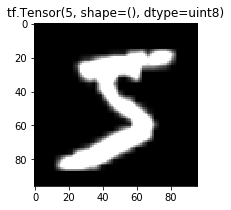

In [9]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from datetime import datetime
import matplotlib.pyplot as plt
import os
import numpy as np
# tf.compat.v1.enable_eager_execution() 
# tf.compat.v1.disable_eager_execution()
keras = keras

# | CONSTANTS
EPOCHS = 1
CLASSES = 10
TENSORBOARD = False
BATCH_SIZE = 32
FREEZE_NR_LAYERS = False # set to False to freeze all layers
IMG_SHAPE = (96, 96)
SHUFFLE_BUFFER_SIZE = 1000
TENSORBOARD = False
CHECKPOINTS = False

# | Helper Functions
def image_preprocessing(image, label):
  image = tf.cast(image, tf.float32)
  image = image/127.5 - 1 # normalization to bring values to range [-1.0, 1.0]
  image = tf.expand_dims(image, -1) # (28,28) -> (28,28,1)
  image = tf.image.resize(image, IMG_SHAPE)
  image = tf.image.grayscale_to_rgb(image)
  
  return image, label

# | Load dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# | Set up Data Pipeline / Convert to Tensorflow tf.data.Dataset
train_data = (train_images, train_labels)
train_data = tf.data.Dataset.from_tensor_slices(train_data)
train_data = train_data.map(image_preprocessing)

test_data = (test_images, test_labels)
test_data = tf.data.Dataset.from_tensor_slices(test_data)
test_data = test_data.map(image_preprocessing)

train_batches = train_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
train_batches = train_batches.repeat(EPOCHS)
test_batches = test_data.batch(BATCH_SIZE)
test_batches = test_batches.repeat(EPOCHS)

#train_iterator = train_batches.make_one_shot_iterator()
#test_iterator = test_batches.make_one_shot_iterator()

for image, label in train_data.take(1):
  plt.figure(figsize=(3,3))
  plt.imshow(image+1)
  plt.title(label)

In [10]:
# | load the pretrained model (include_top=False, removes the input layer and the last fully connected layer (classifier))
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE + (3,), include_top=False, weights='imagenet')
# base_model = keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(DIM,DIM,3), pooling=None, classes=1000)
# base_model = keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(DIM,DIM,3), pooling=None, classes=1000)
# base_model = keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(DIM,DIM,3), pooling=None, classes=1000)

# | freeze the weights
if not FREEZE_NR_LAYERS:
  base_model.trainable = False
else:
  for i in range(FREEZE_NR_LAYERS):
      base_model.layers[i].trainable = False
      print(base_model.layers[i])

# | Create layers for classification head
# global_average_layer = keras.layers.Flatten()
global_average_layer = keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(CLASSES)

# | Create the model
model = keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

# print(base_model.summary())
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [ ]:
# | create directories for tensorboard log_dir and model checkpoints
ts = str(int(datetime.now().timestamp()))
callbacks = []
if TENSORBOARD:
  # | start tensorboard with > tensorboard --logdir=./log
  log_dir = './log/' + ts
  if not os.path.exists(log_dir):
      os.makedirs(log_dir)
  tb_callback = keras.callbacks.TensorBoard(log_dir='.', update_freq='epoch')
  callbacks.append(tb_callback)

      
if CHECKPOINTS:
  checkpoint_dir = './checkpoints/' + ts
  if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)
  checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_dir + '/weights.{epoch:02d}-{val_loss:.2f}.h5')
  callbacks.append(checkpoint_callback)

# | Compile the model
optimizer = 'adam'
# optimizer = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# | Training
STEPS_PER_EPOCH = round(train_images.shape[0])//BATCH_SIZE
VALIDATION_STEPS = 20

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_data=test_batches, 
                    validation_steps=VALIDATION_STEPS,
                    callbacks=callbacks)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()